# **SIIM COVID-19 Detectron2 Inferance 2**

## Training, EDA,and Dataset 
- [SIIM COVID-19 Detectron2 Training](https://www.kaggle.com/ammarnassanalhajali/siim-covid-19-detectron2-training)
- [SIIM-FISABIO-RSNA COVID-19 Detection-EDA](https://www.kaggle.com/ammarnassanalhajali/siim-fisabio-rsna-covid-19-detection-eda)
- [SIIM-COVID-19 Detection Training Labels (Dataset)](https://www.kaggle.com/ammarnassanalhajali/siimcovid19-detection-training-label)



### Hi kagglers, This is `inferance` notebook using `Detectron2`.

> #### Thanks:
> - https://www.kaggle.com/xhlulu/siim-covid19-resized-to-256px-jpg


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

# Detectron2
Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark.

# Installation
* detectron2 is not pre-installed in this kaggle docker, so let's install it.
* we need to know CUDA and pytorch version to install correct detectron2.

In [ ]:
!nvidia-smi

In [ ]:
!nvcc --version

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

* It seems CUDA=11.0 and torch==1.7.0 is used in this kaggle docker image.
* See installation for details. https://detectron2.readthedocs.io/en/latest/tutorials/install.html

# Install Pre-Built Detectron2

In [ ]:
!pip install /kaggle/input/detectron2/omegaconf-2.0.6-py3-none-any.whl

!pip install /kaggle/input/detectron2/iopath-0.1.8-py3-none-any.whl

!pip install /kaggle/input/detectron2/fvcore-0.1.3.post20210317/fvcore-0.1.3.post20210317/

!pip install /kaggle/input/detectron2/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar

!pip install /kaggle/input/detectron2/detectron2-0.4cu110-cp37-cp37m-linux_x86_64.whl

!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

import numpy as np 
import pandas as pd 
from datetime import datetime
import time
from tqdm import tqdm_notebook as tqdm # progress bar
import matplotlib.pyplot as plt

from math import ceil
from typing import Any, Dict, List
from typing import List
from dataclasses import dataclass, field
from typing import Dict
from numpy import ndarray
from glob import glob


import os, json, cv2, random
import skimage.io as io

import pickle
from pathlib import Path
from typing import Optional
from tqdm import tqdm

# numba
import numba
from numba import jit


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

# configs

In [ ]:
# --- configs ---
thing_classes = [
    "atypical",
    "indeterminate",
    "negative",
    "typical"
]
debug=False

category_name_to_id = {class_name: index for index, class_name in enumerate(thing_classes)}
category_name_to_id

# Register Dataset

In [ ]:
import pandas as pd 
df_meta = pd.read_csv("../input/siim-covid19-resized-1024px/meta.csv")
test_meta=df_meta[df_meta.split=="test"]


def get_COVID19_data_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = False,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        df_meta = pd.read_csv("../input/siim-covid19-resized-1024px/meta.csv")
        test_meta=df_meta[df_meta.split=="test"]
        if debug:
            test_meta = test_meta.iloc[:10]  # For debug....
        # Load 1 image to get image size.
        image_id = test_meta.iloc[0,0]
        #image_path = str(imgdir / "test" / f"{image_id}.jpg")
        image_path = str(f'../input/siim-covid19-resized-1024px/test/{image_id}.jpg')
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width,s = test_meta_row.values
            #filename = str(imgdir / "test" / f"{image_id}.jpg")
            filename = str(f'../input/siim-covid19-resized-1024px/test/{image_id}.jpg')
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    #print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts

In [ ]:
imgdir = "../input/siim-covid19-resized-1024px"
DatasetCatalog.register(
    "COVID19_data_test", lambda: get_COVID19_data_dicts_test(imgdir, test_meta, debug=debug)
)


In [ ]:
MetadataCatalog.get("COVID19_data_test").set(thing_classes=thing_classes)
metadata = MetadataCatalog.get("COVID19_data_test")
dataset_dicts = get_COVID19_data_dicts_test(imgdir, test_meta, debug=debug)

# Load model

In [ ]:
from detectron2.config import get_cfg
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
#config_name = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 


cfg.MODEL.WEIGHTS = "../input/d/ammarnassanalhajali/1siim-covid19-detectron2-weights/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.40 # set the testing threshold for this model

predictor = DefaultPredictor(cfg)

In [ ]:
def format_pred(labels: ndarray, boxes: ndarray, scores: ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        if label==2:
            labelstr='none'
        else:
            labelstr='opacity'
        pred_strings.append(f"{labelstr} {score:0.3f} {xmin} {ymin} {xmax} {ymax}") 
    return " ".join(pred_strings)

def predict_batch(predictor: DefaultPredictor, im_list: List[ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

# Inferance

In [ ]:
if debug:
    dataset_dicts = dataset_dicts[:30]

results_list = []
index = 0
batch_size = 1

fig, ax = plt.subplots(2, 5, figsize =(20,8))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3],ax[0][4],ax[1][4] ]


for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        # outputs = predictor(im)
        #############################################################

        if index < 10:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.8,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            # cv2_imshow(out.get_image()[:, :, ::-1])
            #cv2.imwrite(str(outdir / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])
            
            #cv2.imwrite(f"./pred_{index}.jpg", out.get_image()[:, :, ::-1])
            
            indices[index].grid(False)
            indices[index].imshow(out.get_image()[:, :, ::-1])
            
                        
         ###############################################################   
            
            
            
        df_meta = pd.read_csv("../input/siim-covid19-resized-1024px/meta.csv")
        test_meta=df_meta[df_meta.split=="test"]
        
        image_id, dim0, dim1,s = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            # No finding, let's set 2 1.0 0 0 1 1x. Negative
            result = {
                "image_id": image_id +"_image",
                "negative": 1,
                "typical": 0,
                "indeterminate": 0,
                "atypical": 0,
                 "PredictionString": "none 1 0 0 1 1"}
        else:
            # Find some bbox...
            # print(f"index={index}, find {len(instances)} bbox.")
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()
            pred_classes_scores_array=np.stack((pred_classes_array,pred_scores_array), axis=-1)
            #{'atypical': 0, 'indeterminate': 1, 'negative': 2, 'typical': 3}
            
            
            typical= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==3, 1],axis=0)
            negative= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==2, 1],axis=0)
            indeterminate= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==1, 1],axis=0)
            atypical= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==0, 1],axis=0)
            
            total=typical+negative+indeterminate+atypical
            
            typical=typical/total
            negative=negative/total
            indeterminate=indeterminate/total
            atypical=atypical/total
            
                
            result = {
                "image_id": image_id +"_image",
                "negative": negative,
                "typical": typical,
                "indeterminate": indeterminate,
                "atypical": atypical,
                "PredictionString": format_pred(pred_classes_array, pred_boxes_array, pred_scores_array),
            }
        results_list.append(result)
        index += 1

In [ ]:
df_img_pre=None
df_img_pre = pd.DataFrame(results_list)
df_img_pre

In [ ]:
test_df=None
filepaths = glob('/kaggle/input/siim-covid19-detection/test/**/*dcm',recursive=True)
test_df = pd.DataFrame({'filepath':filepaths,})
test_df['image_id'] = test_df.filepath.map(lambda x: x.split('/')[-1].replace('.dcm', '')+'_image')
test_df['study_id'] = test_df.filepath.map(lambda x: x.split('/')[-3].replace('.dcm', '')+'_study')
test_df.drop(['filepath'], axis=1, inplace=True)
test_df

In [ ]:
test_img_pre_df=None
test_img_pre_df=pd.merge(test_df, df_img_pre, on = 'image_id', how = 'left')
test_img_pre_df.sort_values('typical')

In [ ]:
test_img_pre_df=test_img_pre_df.groupby(['study_id']).mean()
test_img_pre_df.reset_index(inplace = True) 
test_img_pre_df.sort_values('typical')
test_img_pre_df=test_img_pre_df.fillna(0)
test_img_pre_df

In [ ]:
import numpy as np 
import pandas as pd

df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
id_laststr_list  = []
for i in range(df.shape[0]):
    id_laststr_list.append(df.loc[i,'id'][-1])
df['id_last_str'] = id_laststr_list
study_len = df[df['id_last_str'] == 'y'].shape[0]
image_len = df[df['id_last_str'] == 'e'].shape[0]
print("study_len:" + str(study_len) + "   image_len:" + str(image_len))
df=df[df.id_last_str == 'y']
df

In [ ]:
df_submission=None
df_submission=pd.merge(df,test_img_pre_df, left_on='id', right_on='study_id', how = 'left')
df_submission=df_submission.fillna(0)
#df_submission.drop(['PredictionString'], axis=1, inplace=True)
df_submission

In [ ]:
import numpy as np 
import pandas as pd 
id_laststr_list  = []
for i in range(df.shape[0]):
    id_laststr_list.append(df.loc[i,'id'][-1])
df['id_last_str'] = id_laststr_list
study_len = df[df['id_last_str'] == 'y'].shape[0]

for i in range(study_len):
    negative =  df_submission.loc[i,'negative'] 
    typical = df_submission.loc[i,'typical']
    indeterminate = df_submission.loc[i,'indeterminate']
    atypical = df_submission.loc[i,'atypical']
    
    negative_st=''
    typical_st=''
    indeterminate_st=''
    atypical_st=''

    if negative>0:
        negative_st =f'negative {negative:0.3f} 0 0 1 1 '
    if typical>0:
        typical_st =f'typical {typical:0.3f} 0 0 1 1 '
    if indeterminate>0:
        indeterminate_st =f'indeterminate {indeterminate:0.3f} 0 0 1 1 '
    if atypical>0:
        atypical_st =f'atypical {atypical:0.3f} 0 0 1 1 '

    #study_str = f'{negative_st}{typical_st}{indeterminate_st}{atypical_st}'
        
    #study_str = 'negative 1 0 0 1 1 atypical 1 0 0 1 1 typical 1 0 0 1 1 indeterminate 1 0 0 1 1'
    study_str = f'negative {negative} 0 0 1 1 typical {typical} 0 0 1 1 indeterminate {indeterminate} 0 0 1 1 atypical {atypical} 0 0 1 1'
    df.loc[i, 'PredictionString'] = study_str
    
submission_file_study = df[['id', 'PredictionString']]
submission_file_study

In [ ]:
submission_file_image = df_img_pre[['image_id', 'PredictionString']]
submission_file_image.rename(columns={'image_id': 'id'}, inplace=True)
submission_file_image.PredictionString="none 1 0 0 1 1"
submission_file_image

In [ ]:
submission_file = pd.concat([submission_file_study, submission_file_image], ignore_index=[True])

In [ ]:
#submission_file.to_csv('submission.csv', index=False)
submission_file

In [ ]:
df = pd.read_csv('../input/siim-covid19-detection/sample_submission.csv')
df.drop(['PredictionString'], axis=1, inplace=True)

In [ ]:
submission_file1 = df.join(submission_file.set_index('id'), on = 'id')

In [ ]:
submission_file1

In [ ]:
submission_file1.to_csv('submission.csv', index=False)

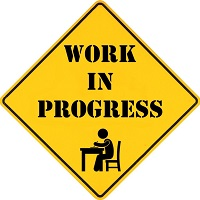

# References
1. https://www.kaggle.com/ammarnassanalhajali/training-detectron2-for-blood-cells-detection
1. https://www.kaggle.com/corochann/vinbigdata-detectron2-train
1. https://www.kaggle.com/corochann/vinbigdata-detectron2-prediction
